##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [7]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [8]:
orig_df = pd.read_csv('../LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [10]:
df = pd.read_csv('../LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [11]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [12]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [13]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [14]:
df.head()

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0


Input Variables:

'X': Represents a location's longitude.
'Y': Represents a location's latitude.
'Area_Command': Categorical variable representing the area command.
'NIBRSOffenseCode': Categorical variable representing the NIBRS offense code.
'DayOfWeek': Categorical variable representing the day of the week.
'Time': Categorical variable representing the time of the day.
Target Variable:

'VictimCount': Categorical variable representing the count of victims. This is typically what you want to predict or analyze.

In [15]:
print(df.describe())


                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000          1.000000    1.000000   
50%   -115.149945   36.152415      3.000000          1.000000    3.000000   
75%   -115.105200   36.183854      6.000000          1.000000    5.000000   
max   -114.625570   37.000000     11.000000          2.000000    6.000000   

             Time  VictimCount  
count  275.000000   275.000000  
mean    11.236364     0.712727  
std      7.039937     0.978427  
min      0.000000     0.000000  
25%      5.000000     0.000000  
50%     11.000000     0.000000  
75%     18.000000     1.000000  
max     23.000000     6.000000  


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [20]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X = torch.tensor(df.drop(columns='VictimCount').values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.float32)

dataset = TensorDataset(X, y)

batch_size = 64

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for batch_X, batch_y in train_loader:
    print("Batch X shape:", batch_X.shape)
    print("Batch y shape:", batch_y.shape)


Batch X shape: torch.Size([64, 6])
Batch y shape: torch.Size([64])
Batch X shape: torch.Size([64, 6])
Batch y shape: torch.Size([64])
Batch X shape: torch.Size([64, 6])
Batch y shape: torch.Size([64])
Batch X shape: torch.Size([64, 6])
Batch y shape: torch.Size([64])
Batch X shape: torch.Size([19, 6])
Batch y shape: torch.Size([19])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

Loss Function: For regression tasks, Mean Squared Error (MSE) is a common loss function that measures the average squared difference between the predicted and actual values. It's a suitable choice for this task.

Output Size: Since you're predicting a single real number (the number of crime victims), the size of the predicted output should be 1.

Architecture: For a simple regression task, a feedforward neural network with one or more hidden layers should suffice. The number of layers and the size of each layer are hyperparameters you can tune based on your data and problem complexity. You can start with a simple architecture.

Optimizer: A commonly used optimizer for training neural networks is Stochastic Gradient Descent (SGD). You can choose a learning rate that suits your problem, typically in the range of 0.01 to 0.0001. It's a hyperparameter you might need to tune.

Training Loop:
Here's a simple training loop below:

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
input_size = X.shape[1] 
hidden_size = 32 
output_size = 1  
model = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
test_X = torch.tensor(df.drop(columns='VictimCount').values, dtype=torch.float32)
test_y = torch.tensor(df['VictimCount'].values, dtype=torch.float32)
test_dataset = TensorDataset(test_X, test_y)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
for epoch in range(num_epochs):
    model.train()  
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")
    model.eval()  
    with torch.no_grad():
        test_loss = 0.0
        for test_batch_X, test_batch_y in test_loader:
            y_pred = model(test_batch_X)
            test_loss += criterion(y_pred, test_batch_y).item()
        avg_test_loss = test_loss / len(test_loader)
        print(f"Epoch {epoch+1} - Test MSE: {avg_test_loss:.4f}")

Epoch 1/10, Avg. Loss: 51.5630
Epoch 1 - Test MSE: 34.8822
Epoch 2/10, Avg. Loss: 26.7431
Epoch 2 - Test MSE: 16.0279
Epoch 3/10, Avg. Loss: 11.3335
Epoch 3 - Test MSE: 5.5884
Epoch 4/10, Avg. Loss: 3.6464
Epoch 4 - Test MSE: 1.4746
Epoch 5/10, Avg. Loss: 1.1570
Epoch 5 - Test MSE: 1.0836
Epoch 6/10, Avg. Loss: 1.2409
Epoch 6 - Test MSE: 1.7945
Epoch 7/10, Avg. Loss: 2.0980
Epoch 7 - Test MSE: 2.0426
Epoch 8/10, Avg. Loss: 1.8469
Epoch 8 - Test MSE: 1.6654
Epoch 9/10, Avg. Loss: 1.4918
Epoch 9 - Test MSE: 1.2213
Epoch 10/10, Avg. Loss: 1.1032
Epoch 10 - Test MSE: 0.9913


/Users/bavi_tesh/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bavi_tesh/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([19])) that is different to the input size (torch.Size([19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Tuning the Model: To improve the model's accuracy, you can experiment with the following hyperparameters:
Learning rate (lr)
Hidden layer size
Number of hidden layers
Activation functions (e.g., ReLU, Tanh, Sigmoid)
You can use techniques like grid search or random search to systematically explore different hyperparameter combinations and choose the one that yields the best performance.
Be cautious about overfitting, and consider adding regularization techniques like dropout or L2 regularization if needed.

## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

Task 4 converts the problem into a classification task by having the participants classify the total number of crime victims. The code can be modified for classification in the following ways: determining the number of classes, altering the architecture, adjusting the loss function, and computing accuracy.

1. Number of Classes: You can look at the unique values in your target variable to determine the number of classes in the output data. You will then know how many classes to anticipate. To obtain unique class values, utilize the `torch.unique()` function.

2. Architecture: To support the categorization task, the architecture must be modified. The final layer's output size needs to be adjusted to correspond with the number of classes. You might use a softmax activation if you have several classes.
    
3. Loss Function: A classification loss function is what you should utilize for classification. Choosing cross-entropy loss is common. You can use `nn.CrossEntropyLoss()` in PyTorch.

4. Accuracy Calculation : Examine the model's predictions against the actual class labels to determine the accuracy for the test data. The ratio of accurate predictions to all test data is known as accuracy.

The architecture, the loss function, and the data type of the target variable have all been altered in this code to suit a classification purpose. For assessment, it computes accuracy on the test data. To increase accuracy, you can experiment with various hyperparameters.

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Convert the DataFrame to PyTorch tensors
X = torch.tensor(df.drop(columns='VictimCount').values, dtype=torch.float32)
y = torch.tensor(df['VictimCount'].values, dtype=torch.long)  # Use long data type for classification

# Find the number of classes
num_classes = len(torch.unique(y))

# Create a TensorDataset
dataset = TensorDataset(X, y)

# Define batch size
batch_size = 64

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create DataLoader objects for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a simple neural network model for classification
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_size = X.shape[1]  # Number of input features
hidden_size = 32  # You can adjust the size of the hidden layer
model = Net(input_size, hidden_size, num_classes)

# Define the loss function (Cross-Entropy) and optimizer (e.g., Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 10

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch_X, batch_y in train_loader:
        # Forward pass
        y_pred = model(batch_X)

        # Compute the loss
        loss = criterion(y_pred, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update weights
        optimizer.step()

        total_loss += loss.item()

    # Calculate and print average loss for this epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg. Loss: {avg_loss:.4f}")

    # Calculate accuracy on the test data
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        y_true = []
        y_pred = []
        for test_batch_X, test_batch_y in test_loader:
            test_outputs = model(test_batch_X)
            _, predicted = torch.max(test_outputs, 1)
            y_true.extend(test_batch_y.tolist())
            y_pred.extend(predicted.tolist())
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Epoch {epoch+1} - Test Accuracy: {accuracy:.4f}")

Epoch 1/10, Avg. Loss: 9.0972
Epoch 1 - Test Accuracy: 0.0000
Epoch 2/10, Avg. Loss: 4.9424
Epoch 2 - Test Accuracy: 0.0727
Epoch 3/10, Avg. Loss: 1.9046
Epoch 3 - Test Accuracy: 0.3455
Epoch 4/10, Avg. Loss: 1.2780
Epoch 4 - Test Accuracy: 0.3818
Epoch 5/10, Avg. Loss: 1.3477
Epoch 5 - Test Accuracy: 0.4727
Epoch 6/10, Avg. Loss: 1.4830
Epoch 6 - Test Accuracy: 0.4000
Epoch 7/10, Avg. Loss: 1.3736
Epoch 7 - Test Accuracy: 0.3636
Epoch 8/10, Avg. Loss: 1.4554
Epoch 8 - Test Accuracy: 0.3636
Epoch 9/10, Avg. Loss: 1.2837
Epoch 9 - Test Accuracy: 0.3636
Epoch 10/10, Avg. Loss: 1.2098
Epoch 10 - Test Accuracy: 0.3636


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

In tasks 3 and 4, we addressed two different types of machine learning problems: regression and classification. In task 3, we tackled the regression problem of predicting the number of crime victims as a real number. We used Mean Squared Error (MSE) as the loss function and designed a simple neural network architecture. In task 4, we shifted to a classification problem where we aimed to predict the number of crime victims as a class number. For this task, we used Cross-Entropy Loss and adapted the model architecture and evaluation metric accordingly.

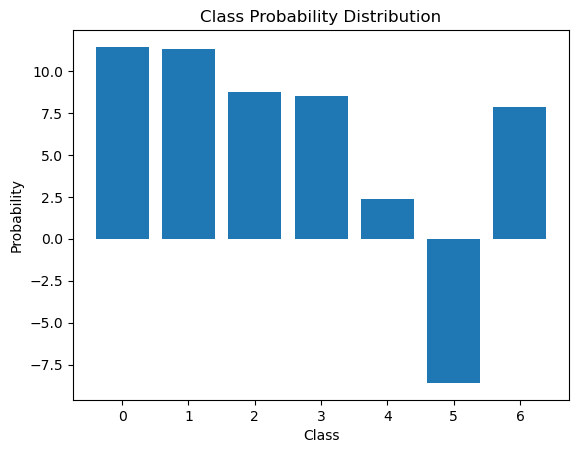

Correct Class: 0, Predicted Class: 0


In [31]:
import matplotlib.pyplot as plt

# Set your model to evaluation mode
model.eval()

# Choose a specific example from the test data for misclassification
example_idx = 0  # Change this to the index of the example you want to investigate
inputs, target = test_dataset[example_idx]

# Forward pass to get predicted probabilities
with torch.no_grad():
    predicted_probs = model(inputs.unsqueeze(0))

# Get the predicted class (index with highest probability)
predicted_class = torch.argmax(predicted_probs).item()

# Plot the probabilities in a bar chart
classes = [str(i) for i in range(num_classes)]  # Assuming class labels are numerical
plt.bar(classes, predicted_probs.squeeze().numpy())
plt.xlabel('Class')
plt.ylabel('Probability')
plt.title('Class Probability Distribution')
plt.show()

# Print the correct class label
correct_class = target.item()
print(f'Correct Class: {correct_class}, Predicted Class: {predicted_class}')


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


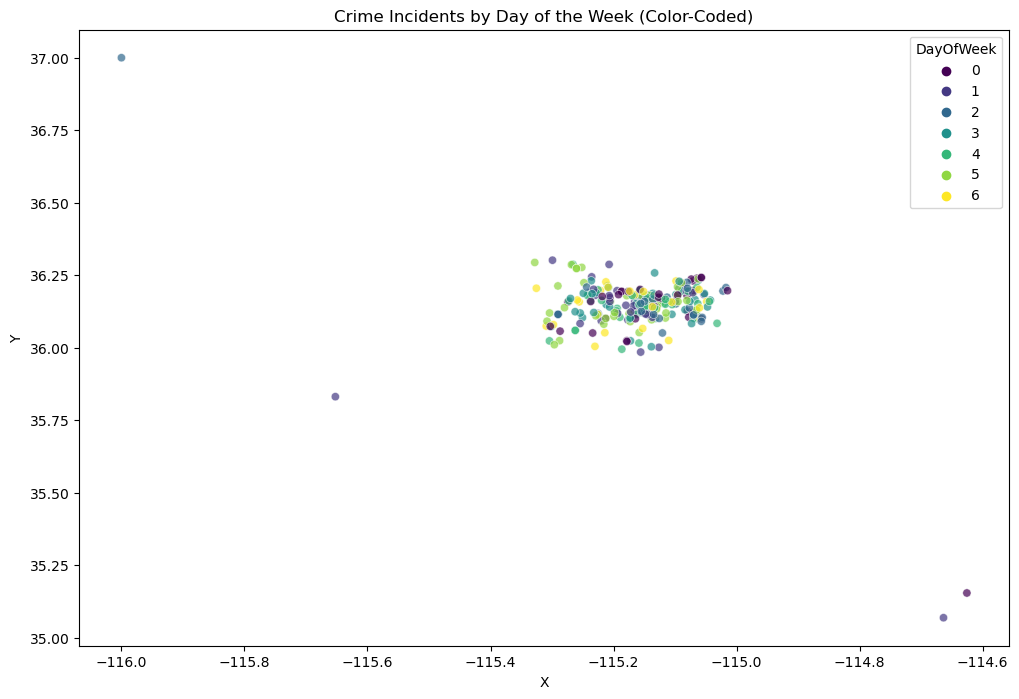

In [32]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='X', y='Y', hue='DayOfWeek', data=df, palette='viridis', alpha=0.7)
plt.title('Crime Incidents by Day of the Week (Color-Coded)')
plt.show()


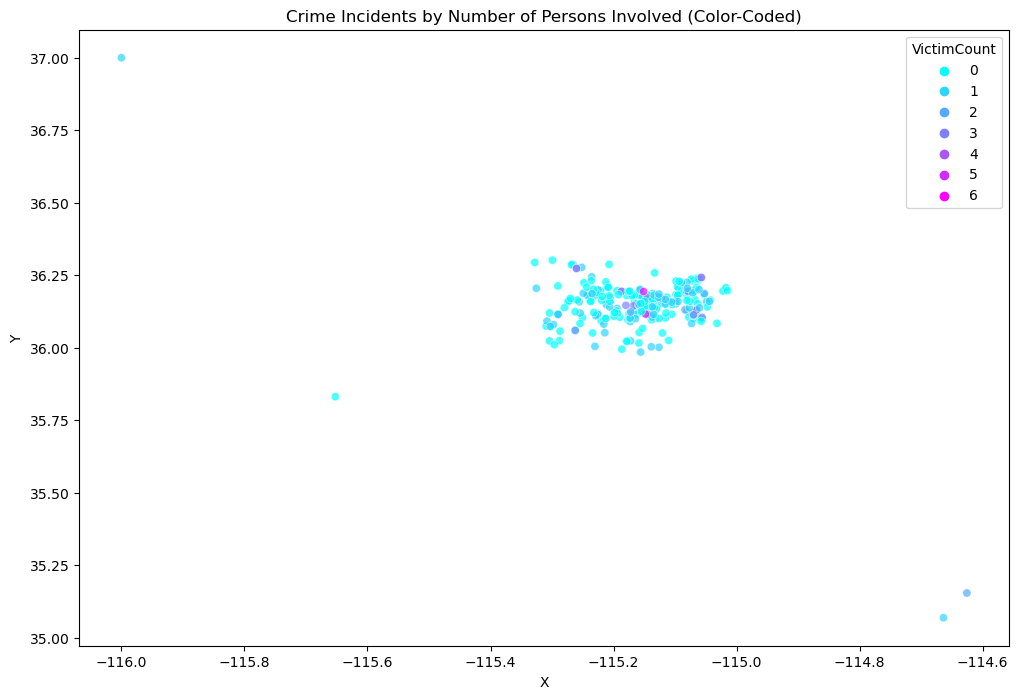

In [33]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='X', y='Y', hue='VictimCount', data=df, palette='cool', alpha=0.7)
plt.title('Crime Incidents by Number of Persons Involved (Color-Coded)')
plt.show()


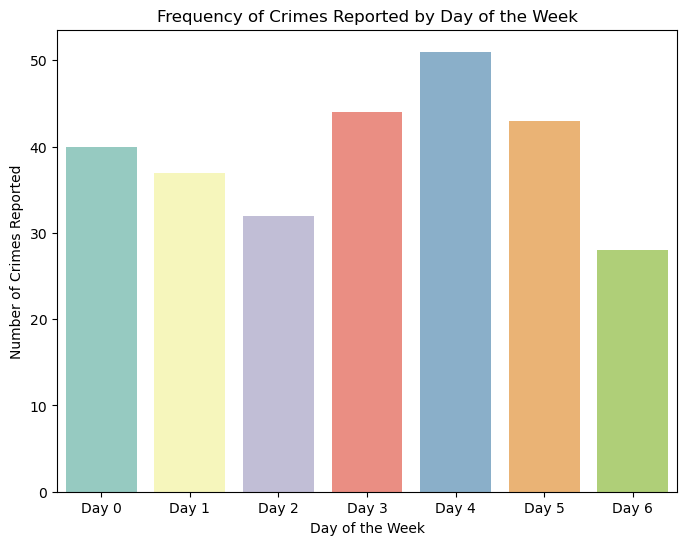

In [34]:
import numpy as np

# Count the number of crimes reported by day of the week
day_counts = np.bincount(df['DayOfWeek'])
days = [f'Day {i}' for i in range(len(day_counts))]

# Create a bar plot to visualize the frequency of crimes by day
plt.figure(figsize=(8, 6))
sns.barplot(x=days, y=day_counts, palette='Set3')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes Reported')
plt.title('Frequency of Crimes Reported by Day of the Week')
plt.show()
